In [3]:
import torch
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import numpy as np
import pandas as pd
import random
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [4]:
def set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).
 
    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
    if is_tf_available():
        import tensorflow as tf
 
        tf.random.set_seed(seed)
 
set_seed(1)

In [6]:
train_path = ''
train_data = pd.read_csv(train_path)

test_path = ''
test_data = pd.read_csv(test_path)

In [8]:
train_data.event_result = train_data.event_result.astype(str)
test_data.event_result = test_data.event_result.astype(str)


In [9]:
train_data['Primary code '].unique()

array(['CE', 'SMC', 'SSI', 'SESU', 'SN', 'CM', 'CP', 'CRF', 'EM', 'TD'],
      dtype=object)

In [10]:
train_data = train_data[train_data['Primary code '] != 'EM']
train_data = train_data[train_data['Primary code '] != 'TD']

test_data = test_data[test_data['Primary code '] != 'EM']
test_data = test_data[test_data['Primary code '] != 'TD']


(array([4.525e+03, 2.030e+02, 5.500e+01, 6.400e+01, 4.600e+01, 7.000e+00,
        2.000e+00, 8.000e+00, 5.000e+00, 0.000e+00, 1.000e+00, 5.000e+00,
        1.600e+01, 0.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  1.  ,  21.55,  42.1 ,  62.65,  83.2 , 103.75, 124.3 , 144.85,
        165.4 , 185.95, 206.5 , 227.05, 247.6 , 268.15, 288.7 , 309.25,
        329.8 , 350.35, 370.9 , 391.45, 412.  ]),
 <a list of 20 Patch objects>)

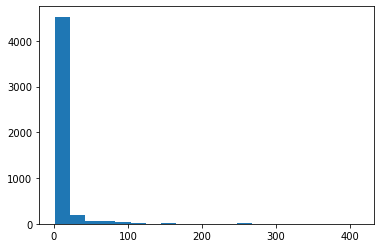

In [11]:
plt.hist([len(x.split()) for x in train_data.event_result], bins=20)

In [13]:
# the model we gonna train, base uncased BERT
# check text classification models here: https://huggingface.co/models?filter=text-classification
model_name = "bert-base-uncased"
# max sequence length for each document/sentence sample
max_length = 50

In [14]:
# load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [15]:
from sklearn import preprocessing

def read_data(test_size=0.2):
  train_texts = list(train_data.event_result)
  valid_texts = list(test_data.event_result)
  le = preprocessing.LabelEncoder()
  le.fit(train_data['Primary code '])
  train_labels = le.transform(train_data['Primary code '])
  valid_labels = le.transform(test_data['Primary code '])
  # split into training & testing a return data as well as label names
  return (train_texts, valid_texts, train_labels, valid_labels), le.classes_
  
# call the function
(train_texts, valid_texts, train_labels, valid_labels), target_names = read_data()

In [17]:
target_names

array(['CE', 'CM', 'CP', 'CRF', 'SESU', 'SMC', 'SN', 'SSI'], dtype=object)

In [19]:
# tokenize the dataset, truncate when passed `max_length`, 
# and pad with 0's when less than `max_length`
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length)

In [20]:
class CPS_dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

# convert our tokenized data into a torch Dataset
train_dataset = CPS_dataset(train_encodings, train_labels)
valid_dataset = CPS_dataset(valid_encodings, valid_labels)

In [21]:
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(target_names))

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [22]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds)
  f1_micro = f1_score(labels, preds, average='micro')
  f1_macro = f1_score(labels, preds, average='macro')
  print(classification_report(labels, preds, labels= [0, 1, 2, 3, 4, 5, 6, 7],  
                              target_names=target_names))
  return {
      'accuracy': acc,
      'f1-micro': f1_micro,
      'f1-macro': f1_macro
  }

In [24]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=4,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps=500,               # log & save weights each logging_steps
    evaluation_strategy="steps",     # evaluate each `logging_steps`
)

In [25]:
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

In [26]:
# train the model
trainer.train()

***** Running training *****
  Num examples = 4942
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2472


Step,Training Loss,Validation Loss,Accuracy,F1-micro,F1-macro
500,1.378600,0.931153,0.677210,0.677210,0.504031
1000,0.855000,0.850982,0.715328,0.715328,0.595070
1500,0.580500,0.929823,0.713706,0.713706,0.596222
2000,0.395200,1.115229,0.725061,0.725061,0.610415


***** Running Evaluation *****
  Num examples = 1233
  Batch size = 20


              precision    recall  f1-score   support

          CE       0.48      0.67      0.56        73
          CM       0.68      0.29      0.41        65
          CP       0.00      0.00      0.00         8
         CRF       0.80      0.13      0.22        94
        SESU       0.66      0.56      0.61       197
         SMC       0.72      0.81      0.76       187
          SN       0.70      0.74      0.72       151
         SSI       0.69      0.83      0.76       458

    accuracy                           0.68      1233
   macro avg       0.59      0.50      0.50      1233
weighted avg       0.68      0.68      0.65      1233



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1233
  Batch size = 20


              precision    recall  f1-score   support

          CE       0.57      0.77      0.65        73
          CM       0.61      0.71      0.65        65
          CP       0.00      0.00      0.00         8
         CRF       0.61      0.47      0.53        94
        SESU       0.64      0.68      0.66       197
         SMC       0.83      0.76      0.79       187
          SN       0.82      0.61      0.70       151
         SSI       0.75      0.80      0.77       458

    accuracy                           0.72      1233
   macro avg       0.60      0.60      0.60      1233
weighted avg       0.72      0.72      0.71      1233



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1233
  Batch size = 20


              precision    recall  f1-score   support

          CE       0.63      0.78      0.70        73
          CM       0.65      0.52      0.58        65
          CP       0.00      0.00      0.00         8
         CRF       0.59      0.57      0.58        94
        SESU       0.67      0.60      0.63       197
         SMC       0.76      0.82      0.79       187
          SN       0.69      0.75      0.72       151
         SSI       0.77      0.76      0.76       458

    accuracy                           0.71      1233
   macro avg       0.60      0.60      0.60      1233
weighted avg       0.71      0.71      0.71      1233



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1233
  Batch size = 20


              precision    recall  f1-score   support

          CE       0.70      0.67      0.69        73
          CM       0.62      0.75      0.68        65
          CP       0.00      0.00      0.00         8
         CRF       0.66      0.51      0.57        94
        SESU       0.64      0.66      0.65       197
         SMC       0.74      0.83      0.78       187
          SN       0.75      0.71      0.73       151
         SSI       0.78      0.78      0.78       458

    accuracy                           0.73      1233
   macro avg       0.61      0.61      0.61      1233
weighted avg       0.72      0.73      0.72      1233



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-1000 (score: 0.8509820699691772).


TrainOutput(global_step=2472, training_loss=0.6962489341069193, metrics={'train_runtime': 205.5403, 'train_samples_per_second': 96.176, 'train_steps_per_second': 12.027, 'total_flos': 507955033017600.0, 'train_loss': 0.6962489341069193, 'epoch': 4.0})

In [27]:
# evaluate the current model after training
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 1233
  Batch size = 20


              precision    recall  f1-score   support

          CE       0.57      0.77      0.65        73
          CM       0.61      0.71      0.65        65
          CP       0.00      0.00      0.00         8
         CRF       0.61      0.47      0.53        94
        SESU       0.64      0.68      0.66       197
         SMC       0.83      0.76      0.79       187
          SN       0.82      0.61      0.70       151
         SSI       0.75      0.80      0.77       458

    accuracy                           0.72      1233
   macro avg       0.60      0.60      0.60      1233
weighted avg       0.72      0.72      0.71      1233



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'epoch': 4.0,
 'eval_accuracy': 0.7153284671532847,
 'eval_f1-macro': 0.5950699824439187,
 'eval_f1-micro': 0.7153284671532847,
 'eval_loss': 0.8509820699691772,
 'eval_runtime': 2.1834,
 'eval_samples_per_second': 564.728,
 'eval_steps_per_second': 28.397}

In [31]:
# saving the fine tuned model & tokenizer
model_path = "./BERT-base-uncased"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

Configuration saved in /content/drive/Shareddrives/La(LA)LAB/Projects/Mellon CPS/Automate CPS Classification/Amin & Nishitha/Amin/BERT-base-uncased/config.json
Model weights saved in /content/drive/Shareddrives/La(LA)LAB/Projects/Mellon CPS/Automate CPS Classification/Amin & Nishitha/Amin/BERT-base-uncased/pytorch_model.bin
tokenizer config file saved in /content/drive/Shareddrives/La(LA)LAB/Projects/Mellon CPS/Automate CPS Classification/Amin & Nishitha/Amin/BERT-base-uncased/tokenizer_config.json
Special tokens file saved in /content/drive/Shareddrives/La(LA)LAB/Projects/Mellon CPS/Automate CPS Classification/Amin & Nishitha/Amin/BERT-base-uncased/special_tokens_map.json


('/content/drive/Shareddrives/La(LA)LAB/Projects/Mellon CPS/Automate CPS Classification/Amin & Nishitha/Amin/BERT-base-uncased/tokenizer_config.json',
 '/content/drive/Shareddrives/La(LA)LAB/Projects/Mellon CPS/Automate CPS Classification/Amin & Nishitha/Amin/BERT-base-uncased/special_tokens_map.json',
 '/content/drive/Shareddrives/La(LA)LAB/Projects/Mellon CPS/Automate CPS Classification/Amin & Nishitha/Amin/BERT-base-uncased/vocab.txt',
 '/content/drive/Shareddrives/La(LA)LAB/Projects/Mellon CPS/Automate CPS Classification/Amin & Nishitha/Amin/BERT-base-uncased/added_tokens.json',
 '/content/drive/Shareddrives/La(LA)LAB/Projects/Mellon CPS/Automate CPS Classification/Amin & Nishitha/Amin/BERT-base-uncased/tokenizer.json')

In [32]:
# reload model/tokenizer
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=len(target_names))
tokenizer = BertTokenizerFast.from_pretrained(model_path)

In [33]:
def get_prediction(text):
    # prepare our text into tokenized sequence
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    # perform inference to our model
    outputs = model(**inputs)
    # get output probabilities by doing softmax
    probs = outputs[0].softmax(1)
    # executing argmax function to get the candidate label
    return target_names[probs.argmax()]